# AORC Precipitation for HEC-RAS Rain-on-Grid Models

This notebook demonstrates a complete workflow for using NOAA's Analysis of Record for Calibration (AORC) gridded precipitation data with HEC-RAS 2D rain-on-grid models.

**Example Project**: BaldEagleCrkMulti2D

## Workflow
1. Extract example project and create a labeled working copy
2. Get project bounds from geometry HDF (with buffer)
3. Generate a storm catalog from historical AORC data
4. Download precipitation, export hyetographs, and create HEC-RAS plans
5. Execute all plans in parallel (2 cores, 3 workers)
6. Extract and compare results

## Data Export
All precipitation data is exported to the `Precipitation/` subfolder:
- `storm_catalog.csv` - Complete storm catalog with metadata
- `storm_YYYYMMDD.nc` - NetCDF precipitation files
- `hyetographs/` - PNG plots of each storm's precipitation
- `storm_catalog_summary.png` - Overview plot of all storms

## AORC Dataset Overview
- **Coverage**: CONUS (1979-present), Alaska (1981-present)
- **Resolution**: ~800 meters, hourly timesteps
- **Format**: Cloud-optimized Zarr on AWS S3
- **Access**: Anonymous (no authentication required)

In [1]:
# Install dependencies (uncomment if needed)
# !pip install ras-commander[precip]  # Includes xarray, zarr, s3fs, netCDF4, rioxarray

In [2]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import init_ras_project, RasExamples, RasPlan, RasUnsteady, RasCmdr
from ras_commander.precip import PrecipAorc
from ras_commander.hdf.HdfProject import HdfProject

# Additional imports
import os
import shutil
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📦 PIP PACKAGE MODE: Loading installed ras-commander
✓ Loaded: c:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\ras_commander\__init__.py


## Parameters

Configure these values to customize the notebook for your project.

In [ ]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "Muncie"           # Example project to extract
RAS_VERSION = "6.6"               # HEC-RAS version (6.3, 6.5, 6.6, etc.)

# Output Configuration
OUTPUTS_DIR = Path("_outputs") / "901_aorc_precipitation_catalog"  # Artifacts saved here

# AORC Settings
ONLINE = True                     # Enable network requests

# Create output directory
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Outputs will be saved to: {OUTPUTS_DIR.absolute()}")


### AORC Catalog Verification

**After generating precipitation catalog**:

- [ ] Storm events span simulation period + warmup time
- [ ] Total depths comparable to Atlas 14 estimates (within 20%)
- [ ] Inter-event separation prevents storm merging (8+ hours typical)
- [ ] Spatial coverage includes entire watershed (50% buffer minimum)

**Data Quality Checks**:
```python
# Example: Compare catalog storms to Atlas 14
# (See NOAA Atlas 14: https://hdsc.nws.noaa.gov/hdsc/pfds/)
for storm in storm_catalog.iterrows():
    total_depth = storm['total_depth_in']
    duration = storm['duration_hours']
    # Compare to Atlas 14 for this duration/return period
    # Document if >20% different (grid vs point)
```

**References**:
- [NOAA Atlas 14: Precipitation-Frequency Atlas](https://hdsc.nws.noaa.gov/hdsc/pfds/)
- [AORC Documentation](https://hydrology.nws.noaa.gov/aorc-historic/)

## Step 1: Extract Example Project and Create Working Copy

We extract the BaldEagleCrkMulti2D example and create a labeled copy for our AORC analysis.
**Note**: Existing AORC folders are deleted to ensure repeatability.

In [3]:
# Configuration
YEAR = 2020  # Year to analyze
TEMPLATE_PLAN = "06"  # Template plan with precipitation enabled (DSS-based, version 6.00)
NUM_CORES = 2  # Cores per HEC-RAS instance
MAX_WORKERS = 3  # Parallel worker processes

# Extract base example project
base_project = RasExamples.extract_project(PROJECT_NAME, suffix=SUFFIX)
print(f"Base project extracted to: {base_project}")

# Clean up any existing AORC folders (for repeatability)
print("\nCleaning up existing AORC folders...")
aorc_pattern = base_project.parent / "BaldEagleCrkMulti2D_AORC_*"
existing_folders = list(base_project.parent.glob("BaldEagleCrkMulti2D_AORC_*"))
for folder in existing_folders:
    if folder.is_dir():
        print(f"  Removing: {folder.name}")
        shutil.rmtree(folder)
print(f"  Removed {len(existing_folders)} existing folders")

# Create labeled working copy
working_folder = base_project.parent / f"BaldEagleCrkMulti2D_AORC_{YEAR}"
print(f"\nCreating working copy: {working_folder}")
shutil.copytree(base_project, working_folder)

# Initialize project
ras = init_ras_project(working_folder, RAS_VERSION)
SUFFIX = "901"  # Notebook identifier
print(f"\nProject: {ras.project_name}")
print(f"Location: {ras.project_folder}")
print(f"Plans: {len(ras.plan_df)}")

2025-12-17 22:05:05 - ras_commander.RasExamples - INFO - Found zip file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\Example_Projects_6_6.zip
2025-12-17 22:05:05 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-12-17 22:05:05 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-12-17 22:05:05 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-12-17 22:05:05 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D'
2025-12-17 22:05:05 - ras_commander.RasExamples - INFO - Folder 'BaldEagleCrkMulti2D' already exists. Deleting existing folder...
2025-12-17 22:05:05 - ras_commander.RasExamples - INFO - Existing folder 'BaldEagleCrkMulti2D' has been deleted.
2025-12-17 22:05:06 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to c:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2

Base project extracted to: c:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D

Cleaning up existing AORC folders...
  Removing: BaldEagleCrkMulti2D_AORC_2020
  Removing: BaldEagleCrkMulti2D_AORC_2020 [Worker 1]
  Removing: BaldEagleCrkMulti2D_AORC_2020 [Worker 2]
  Removing: BaldEagleCrkMulti2D_AORC_2020 [Worker 3]
  Removed 4 existing folders

Creating working copy: c:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020


2025-12-17 22:05:09 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\BaldEagleDamBrk.rasmap



Project: BaldEagleDamBrk
Location: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020
Plans: 11


## Step 2: Get Project Bounds from Geometry HDF

Use `HdfProject.get_project_bounds_latlon()` to extract proper bounds with buffering.
This handles CRS transformation and ensures precipitation coverage.

In [4]:
# Get geometry HDF path from template plan
# The 'Geom File' column contains just the number (e.g., "09"),
# so we need to add the "g" prefix for the geometry file extension
template_row = ras.plan_df[ras.plan_df['plan_number'] == TEMPLATE_PLAN].iloc[0]
geom_number = template_row['Geom File']
geom_hdf = ras.project_folder / f"{ras.project_name}.g{geom_number}.hdf"

print(f"Template plan {TEMPLATE_PLAN} uses geometry: g{geom_number}")
print(f"Geometry HDF: {geom_hdf}")
print(f"Exists: {geom_hdf.exists()}")

# Get bounds with 50% buffer (default)
# This properly handles CRS transformation and includes 2D mesh, 1D elements, and storage areas
bounds = HdfProject.get_project_bounds_latlon(
    geom_hdf,
    buffer_percent=50.0,  # 50% buffer ensures full coverage after reprojection
    include_1d=True,
    include_2d=True,
    include_storage=True
)

west, south, east, north = bounds
print(f"\nProject Bounds (WGS84 with 50% buffer):")
print(f"  West:  {west:.4f}")
print(f"  South: {south:.4f}")
print(f"  East:  {east:.4f}")
print(f"  North: {north:.4f}")
print(f"  Size:  {east-west:.4f} x {north-south:.4f} degrees")

2025-12-17 22:05:09 - ras_commander.hdf.HdfProject - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\BaldEagleDamBrk.g09.hdf
2025-12-17 22:05:09 - ras_commander.hdf.HdfProject - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\BaldEagleDamBrk.g09.hdf
2025-12-17 22:05:09 - ras_commander.hdf.HdfProject - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\BaldEagleDamBrk.g09.hdf
2025-12-17 22:05:09 - ras_commander.hdf.HdfProject - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\BaldEagleDamBrk.g09.hdf
2025-12-17 22:05:09 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-comm

Template plan 06 uses geometry: g09
Geometry HDF: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\BaldEagleDamBrk.g09.hdf
Exists: True

Project Bounds (WGS84 with 50% buffer):
  West:  -77.8672
  South: 40.9044
  East:  -77.2192
  North: 41.2408
  Size:  0.6480 x 0.3364 degrees


## Step 3: Generate Storm Catalog

Analyze AORC data to identify all significant precipitation events for the year.

In [5]:
# Generate storm catalog
storm_catalog = PrecipAorc.get_storm_catalog(
    bounds=bounds,
    year=YEAR,
    inter_event_hours=8.0,      # USGS standard for storm separation
    min_depth_inches=0.75,      # Minimum significant precipitation
    buffer_hours=48             # Simulation warmup buffer
)

print(f"\nStorm Catalog: {len(storm_catalog)} events for {YEAR}")
print("="*90)
print(storm_catalog[['storm_id', 'start_time', 'end_time', 'total_depth_in', 
                     'peak_intensity_in_hr', 'duration_hours', 'rank']].to_string(index=False))

2025-12-17 22:05:10 - ras_commander.precip.PrecipAorc - INFO - Generating storm catalog for 2020
2025-12-17 22:05:10 - ras_commander.precip.PrecipAorc - INFO -   Bounds: W=-77.8672, S=40.9044, E=-77.2192, N=41.2408
2025-12-17 22:05:10 - ras_commander.precip.PrecipAorc - INFO -   Parameters: inter_event=8.0h, min_depth=0.75in, buffer=48h
2025-12-17 22:05:10 - ras_commander.precip.PrecipAorc - INFO - Connecting to AWS S3...
2025-12-17 22:05:10 - ras_commander.precip.PrecipAorc - INFO - Loading s3://noaa-nws-aorc-v1-1-1km/2020.zarr...
2025-12-17 22:05:11 - ras_commander.precip.PrecipAorc - INFO - Loading spatial subset...
2025-12-17 22:05:12 - ras_commander.precip.PrecipAorc - INFO - Loaded 8784 hourly timesteps
2025-12-17 22:05:12 - ras_commander.precip.PrecipAorc - INFO - Identified 137 raw events
2025-12-17 22:05:12 - ras_commander.precip.PrecipAorc - INFO - Storm catalog complete: 12 storms
2025-12-17 22:05:12 - ras_commander.precip.PrecipAorc - INFO -   Total depth range: 0.76 - 2.72


Storm Catalog: 12 events for 2020
 storm_id          start_time            end_time  total_depth_in  peak_intensity_in_hr  duration_hours  rank
        1 2020-02-07 09:00:00 2020-02-07 17:00:00           1.023                 0.287               9     9
        2 2020-03-19 01:00:00 2020-03-19 10:00:00           0.763                 0.209              10    12
        3 2020-03-28 08:00:00 2020-03-29 11:00:00           1.530                 0.156              28     6
        4 2020-04-17 17:00:00 2020-04-18 08:00:00           0.777                 0.093              16    11
        5 2020-04-30 04:00:00 2020-05-01 00:00:00           2.115                 0.203              21     2
        6 2020-05-28 12:00:00 2020-05-30 01:00:00           1.188                 0.284              38     8
        7 2020-06-03 06:00:00 2020-06-03 22:00:00           0.846                 0.360              17    10
        8 2020-09-29 11:00:00 2020-09-30 08:00:00           1.278                 0.1

## Step 4: Download AORC Data and Export Precipitation Records

Download precipitation data, export storm catalog CSV, and generate hyetograph plots for documentation.

In [6]:
# Create precipitation folder structure
precip_folder = ras.project_folder / "Precipitation"
precip_folder.mkdir(exist_ok=True)
hyetograph_folder = precip_folder / "hyetographs"
hyetograph_folder.mkdir(exist_ok=True)

# Export storm catalog to CSV
catalog_csv = precip_folder / "storm_catalog.csv"
storm_catalog.to_csv(catalog_csv, index=False)
print(f"Storm catalog exported to: {catalog_csv}")

# Download AORC data for all storms
print(f"\nDownloading AORC precipitation data for {len(storm_catalog)} storms...")
print("="*70)

precip_files = {}
for idx, storm in storm_catalog.iterrows():
    storm_id = storm['storm_id']
    date_str = storm['start_time'].strftime('%Y%m%d')
    precip_file = precip_folder / f"storm_{date_str}.nc"
    
    if not precip_file.exists():
        print(f"  Storm {storm_id:2d}: {storm['start_time'].strftime('%b %d')} - Downloading...")
        PrecipAorc.download(
            bounds=bounds,
            start_time=storm['sim_start'],
            end_time=storm['sim_end'],
            output_path=precip_file,
            target_crs="EPSG:5070",
            resolution=2000.0
        )
    else:
        print(f"  Storm {storm_id:2d}: {storm['start_time'].strftime('%b %d')} - Already downloaded")
    
    precip_files[storm_id] = precip_file

print(f"\nDownloaded {len(precip_files)} precipitation files to {precip_folder}")

2025-12-17 22:05:12 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:
2025-12-17 22:05:12 - ras_commander.precip.PrecipAorc - INFO -   Bounds: W=-77.8672, S=40.9044, E=-77.2192, N=41.2408
2025-12-17 22:05:12 - ras_commander.precip.PrecipAorc - INFO -   Time range: 2020-02-05 09:00:00 to 2020-02-09 17:00:00
2025-12-17 22:05:12 - ras_commander.precip.PrecipAorc - INFO -   Variable: APCP_surface
2025-12-17 22:05:12 - ras_commander.precip.PrecipAorc - INFO - Connecting to AWS S3...
2025-12-17 22:05:12 - ras_commander.precip.PrecipAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


Storm catalog exported to: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_catalog.csv

  Storm  1: Feb 07 - Downloading...


2025-12-17 22:05:13 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 120, 'latitude': 40, 'longitude': 77})
2025-12-17 22:05:13 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...
2025-12-17 22:05:13 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...
2025-12-17 22:05:13 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (120, 24, 30)
2025-12-17 22:05:13 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20200207.nc
2025-12-17 22:05:13 - ras_commander.precip.PrecipAorc - INFO - Download complete: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20200207.nc (0.2 MB)
2025-12-17 22:05:13 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:
2025-12-17 22:05:13 - ras_commande

  Storm  2: Mar 19 - Downloading...


2025-12-17 22:05:13 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 120, 'latitude': 40, 'longitude': 77})
2025-12-17 22:05:13 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...
2025-12-17 22:05:13 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...
2025-12-17 22:05:13 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (120, 24, 30)
2025-12-17 22:05:13 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20200319.nc
2025-12-17 22:05:13 - ras_commander.precip.PrecipAorc - INFO - Download complete: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20200319.nc (0.2 MB)
2025-12-17 22:05:13 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:
2025-12-17 22:05:13 - ras_commande

  Storm  3: Mar 28 - Downloading...


2025-12-17 22:05:14 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 40, 'longitude': 77})
2025-12-17 22:05:14 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...
2025-12-17 22:05:14 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...
2025-12-17 22:05:14 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (144, 24, 30)
2025-12-17 22:05:14 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20200328.nc
2025-12-17 22:05:14 - ras_commander.precip.PrecipAorc - INFO - Download complete: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20200328.nc (0.2 MB)
2025-12-17 22:05:14 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:
2025-12-17 22:05:14 - ras_commande

  Storm  4: Apr 17 - Downloading...


2025-12-17 22:05:14 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 40, 'longitude': 77})
2025-12-17 22:05:14 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...
2025-12-17 22:05:14 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...
2025-12-17 22:05:14 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (144, 24, 30)
2025-12-17 22:05:14 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20200417.nc
2025-12-17 22:05:14 - ras_commander.precip.PrecipAorc - INFO - Download complete: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20200417.nc (0.2 MB)
2025-12-17 22:05:14 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:
2025-12-17 22:05:14 - ras_commande

  Storm  5: Apr 30 - Downloading...


2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 40, 'longitude': 77})
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (144, 24, 30)
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20200430.nc
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Download complete: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20200430.nc (0.2 MB)
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:
2025-12-17 22:05:15 - ras_commande

  Storm  6: May 28 - Downloading...


2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 168, 'latitude': 40, 'longitude': 77})
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (168, 24, 30)
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20200528.nc
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Download complete: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20200528.nc (0.3 MB)
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:
2025-12-17 22:05:15 - ras_commande

  Storm  7: Jun 03 - Downloading...


2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 120, 'latitude': 40, 'longitude': 77})
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (120, 24, 30)
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20200603.nc
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Download complete: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20200603.nc (0.2 MB)
2025-12-17 22:05:15 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:
2025-12-17 22:05:15 - ras_commande

  Storm  8: Sep 29 - Downloading...


2025-12-17 22:05:16 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 40, 'longitude': 77})
2025-12-17 22:05:16 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...
2025-12-17 22:05:16 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...
2025-12-17 22:05:16 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (144, 24, 30)
2025-12-17 22:05:16 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20200929.nc
2025-12-17 22:05:16 - ras_commander.precip.PrecipAorc - INFO - Download complete: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20200929.nc (0.2 MB)
2025-12-17 22:05:16 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:
2025-12-17 22:05:16 - ras_commande

  Storm  9: Oct 29 - Downloading...


2025-12-17 22:05:16 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 40, 'longitude': 77})
2025-12-17 22:05:16 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...
2025-12-17 22:05:16 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...
2025-12-17 22:05:16 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (144, 24, 30)
2025-12-17 22:05:16 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20201029.nc
2025-12-17 22:05:16 - ras_commander.precip.PrecipAorc - INFO - Download complete: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20201029.nc (0.2 MB)
2025-12-17 22:05:16 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:
2025-12-17 22:05:16 - ras_commande

  Storm 10: Nov 11 - Downloading...


2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 120, 'latitude': 40, 'longitude': 77})
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (120, 24, 30)
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20201111.nc
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Download complete: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20201111.nc (0.2 MB)
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:
2025-12-17 22:05:17 - ras_commande

  Storm 11: Dec 16 - Downloading...


2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 40, 'longitude': 77})
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (144, 24, 30)
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20201216.nc
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Download complete: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20201216.nc (0.2 MB)
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Downloading AORC data:
2025-12-17 22:05:17 - ras_commande

  Storm 12: Dec 24 - Downloading...


2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO -     Loaded Frozen({'time': 144, 'latitude': 40, 'longitude': 77})
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Combining datasets...
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Reprojecting to EPSG:5070 at 2000.0m resolution...
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Reprojected grid shape: (144, 24, 30)
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Writing to NetCDF: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20201224.nc
2025-12-17 22:05:17 - ras_commander.precip.PrecipAorc - INFO - Download complete: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_20201224.nc (0.2 MB)



Downloaded 12 precipitation files to C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation


In [7]:
# Generate and save individual hyetograph plots for each storm
print(f"Generating hyetograph plots for {len(storm_catalog)} storms...")
print("="*70)

for idx, storm in storm_catalog.iterrows():
    storm_id = storm['storm_id']
    date_str = storm['start_time'].strftime('%Y%m%d')
    precip_file = precip_files[storm_id]
    
    # Load precipitation data
    ds = xr.open_dataset(precip_file)
    da = ds['APCP_surface']
    hourly_mean = da.mean(dim=['x', 'y']).values
    times = pd.to_datetime(da.time.values)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(times, hourly_mean, width=0.03, color='steelblue', alpha=0.8, edgecolor='darkblue', linewidth=0.5)
    
    # Add storm info
    ax.set_title(f"Storm {storm_id}: {storm['start_time'].strftime('%B %d, %Y')}\n"
                 f"Total: {storm['total_depth_in']:.2f} in | Peak: {storm['peak_intensity_in_hr']:.3f} in/hr | "
                 f"Duration: {storm['duration_hours']:.0f} hours", fontsize=12, fontweight='bold')
    ax.set_xlabel('Date/Time', fontsize=11)
    ax.set_ylabel('Precipitation Rate (mm/hr)', fontsize=11)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Add statistics box
    stats_text = (f"Max Rate: {hourly_mean.max():.2f} mm/hr\n"
                  f"Total: {hourly_mean.sum():.1f} mm\n"
                  f"Timesteps: {len(hourly_mean)}")
    ax.text(0.98, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    
    # Save plot
    plot_path = hyetograph_folder / f"storm_{date_str}_hyetograph.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    ds.close()
    print(f"  Storm {storm_id:2d}: {storm['start_time'].strftime('%b %d')} - Saved to {plot_path.name}")

print(f"\nHyetographs saved to: {hyetograph_folder}")

Generating hyetograph plots for 12 storms...
  Storm  1: Feb 07 - Saved to storm_20200207_hyetograph.png
  Storm  2: Mar 19 - Saved to storm_20200319_hyetograph.png
  Storm  3: Mar 28 - Saved to storm_20200328_hyetograph.png
  Storm  4: Apr 17 - Saved to storm_20200417_hyetograph.png
  Storm  5: Apr 30 - Saved to storm_20200430_hyetograph.png
  Storm  6: May 28 - Saved to storm_20200528_hyetograph.png
  Storm  7: Jun 03 - Saved to storm_20200603_hyetograph.png
  Storm  8: Sep 29 - Saved to storm_20200929_hyetograph.png
  Storm  9: Oct 29 - Saved to storm_20201029_hyetograph.png
  Storm 10: Nov 11 - Saved to storm_20201111_hyetograph.png
  Storm 11: Dec 16 - Saved to storm_20201216_hyetograph.png
  Storm 12: Dec 24 - Saved to storm_20201224_hyetograph.png

Hyetographs saved to: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\hyetographs


Summary plot saved to: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation\storm_catalog_summary.png


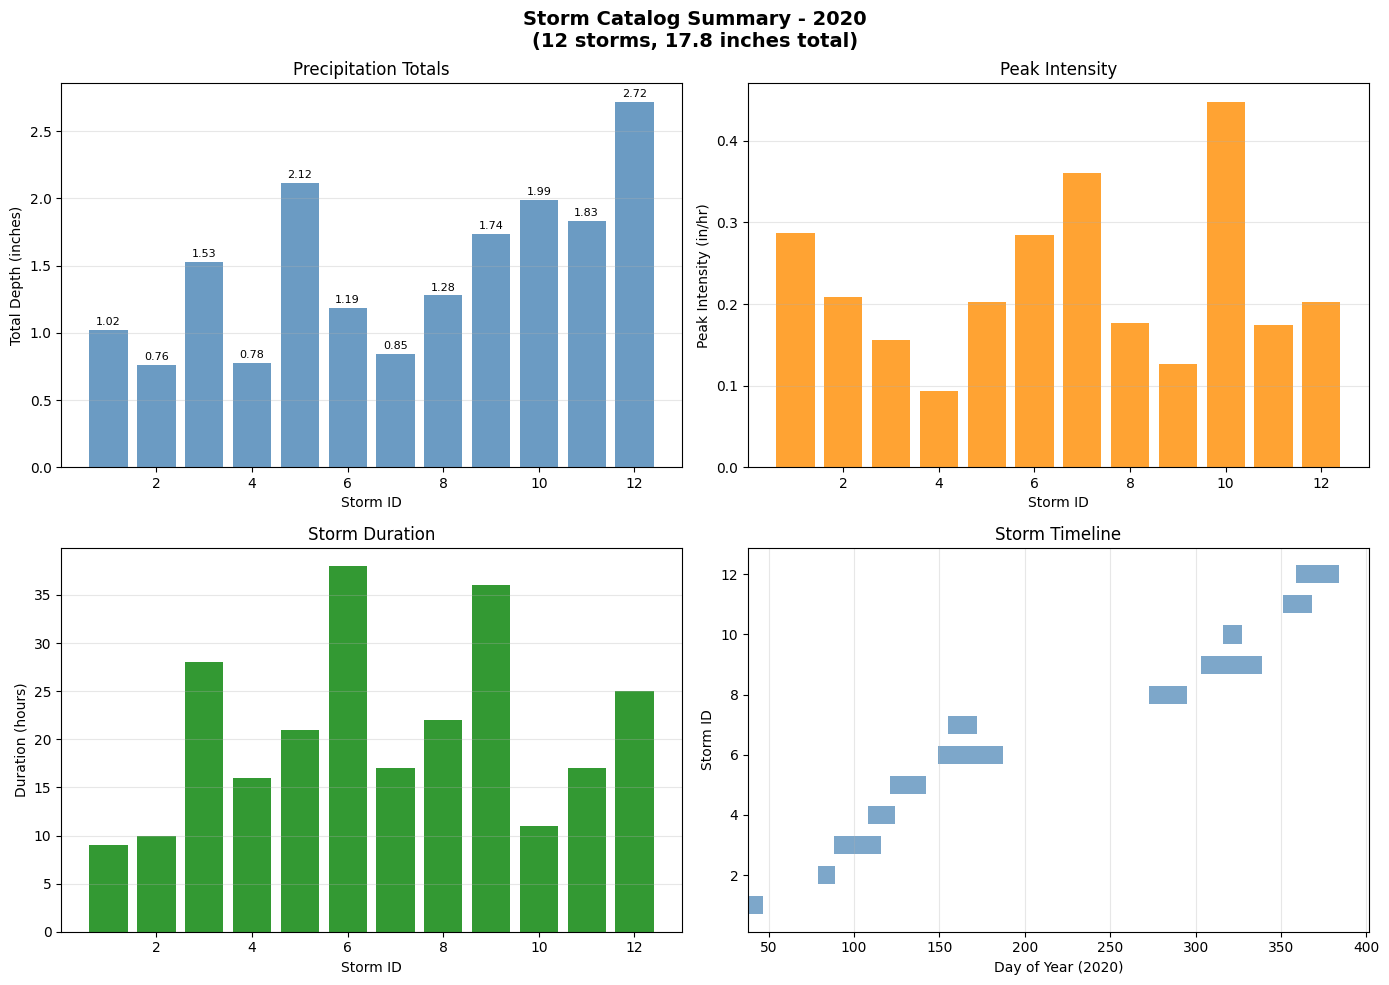

In [8]:
# Create storm catalog summary plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Total depth by storm
ax1 = axes[0, 0]
bars1 = ax1.bar(storm_catalog['storm_id'], storm_catalog['total_depth_in'], color='steelblue', alpha=0.8)
ax1.set_xlabel('Storm ID')
ax1.set_ylabel('Total Depth (inches)')
ax1.set_title('Precipitation Totals')
ax1.grid(True, alpha=0.3, axis='y')
# Add value labels
for bar, val in zip(bars1, storm_catalog['total_depth_in']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.2f}',
             ha='center', va='bottom', fontsize=8)

# 2. Peak intensity
ax2 = axes[0, 1]
bars2 = ax2.bar(storm_catalog['storm_id'], storm_catalog['peak_intensity_in_hr'], color='darkorange', alpha=0.8)
ax2.set_xlabel('Storm ID')
ax2.set_ylabel('Peak Intensity (in/hr)')
ax2.set_title('Peak Intensity')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Duration
ax3 = axes[1, 0]
bars3 = ax3.bar(storm_catalog['storm_id'], storm_catalog['duration_hours'], color='green', alpha=0.8)
ax3.set_xlabel('Storm ID')
ax3.set_ylabel('Duration (hours)')
ax3.set_title('Storm Duration')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Timeline
ax4 = axes[1, 1]
for idx, storm in storm_catalog.iterrows():
    ax4.barh(storm['storm_id'], storm['duration_hours'], left=storm['start_time'].dayofyear,
             color='steelblue', alpha=0.7, height=0.6)
ax4.set_xlabel(f'Day of Year ({YEAR})')
ax4.set_ylabel('Storm ID')
ax4.set_title('Storm Timeline')
ax4.grid(True, alpha=0.3, axis='x')

plt.suptitle(f'Storm Catalog Summary - {YEAR}\n({len(storm_catalog)} storms, '
             f'{storm_catalog["total_depth_in"].sum():.1f} inches total)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()

# Save summary plot
summary_path = precip_folder / "storm_catalog_summary.png"
plt.savefig(summary_path, dpi=150, bbox_inches='tight')
print(f"Summary plot saved to: {summary_path}")
plt.show()

In [9]:
# Create storm plans with precipitation data written to HDF
print(f"Creating HEC-RAS plans for {len(storm_catalog)} storms...")
print("="*70)

# Use create_storm_plans which calls set_gridded_precipitation
# This writes precipitation data directly to the .u##.hdf file
results = PrecipAorc.create_storm_plans(
    storm_catalog=storm_catalog,
    bounds=bounds,
    template_plan=TEMPLATE_PLAN,
    precip_folder="Precipitation",
    ras_object=ras,
    download_data=False  # Already downloaded above
)

# Show results
print(f"\nPlan Creation Results:")
print(results[['storm_id', 'start_time', 'total_depth_in', 'plan_number', 'status']].to_string(index=False))

# Refresh plan list
ras.plan_df = ras.get_plan_entries()
print(f"\nTotal plans in project: {len(ras.plan_df)}")

2025-12-17 22:05:23 - ras_commander.precip.PrecipAorc - INFO - Creating storm plans from template plan 06 (unsteady 03)
2025-12-17 22:05:23 - ras_commander.precip.PrecipAorc - INFO -   Precipitation folder: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation
2025-12-17 22:05:23 - ras_commander.precip.PrecipAorc - INFO -   Processing 12 storms
2025-12-17 22:05:23 - ras_commander.precip.PrecipAorc - INFO - Storm 1: 2020-02-07 (1.02 in)
2025-12-17 22:05:23 - ras_commander.precip.PrecipAorc - INFO -   Cloning unsteady file...
2025-12-17 22:05:23 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\BaldEagleDamBrk.u03 to C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\BaldEagleDamBrk.u04
2025-12-17 22:05:23 - ras_commander.RasUtils - INFO - Successfully updated 

Creating HEC-RAS plans for 12 storms...


2025-12-17 22:05:23 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\BaldEagleDamBrk.rasmap
2025-12-17 22:05:24 - ras_commander.RasPlan - INFO - Updated simulation date in plan file: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\BaldEagleDamBrk.p07
2025-12-17 22:05:24 - ras_commander.precip.PrecipAorc - INFO -   Enabled HDF time series output
2025-12-17 22:05:24 - ras_commander.precip.PrecipAorc - INFO -   Created plan 07 with unsteady 04
2025-12-17 22:05:24 - ras_commander.precip.PrecipAorc - INFO - Storm 2: 2020-03-19 (0.76 in)
2025-12-17 22:05:24 - ras_commander.precip.PrecipAorc - INFO -   Cloning unsteady file...
2025-12-17 22:05:24 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\BaldEagle


Plan Creation Results:
 storm_id          start_time  total_depth_in plan_number  status
        1 2020-02-07 09:00:00           1.023          07 success
        2 2020-03-19 01:00:00           0.763          08 success
        3 2020-03-28 08:00:00           1.530          09 success
        4 2020-04-17 17:00:00           0.777          10 success
        5 2020-04-30 04:00:00           2.115          11 success
        6 2020-05-28 12:00:00           1.188          12 success
        7 2020-06-03 06:00:00           0.846          14 success
        8 2020-09-29 11:00:00           1.278          16 success
        9 2020-10-29 07:00:00           1.735          20 success
       10 2020-11-11 12:00:00           1.989          21 success
       11 2020-12-16 17:00:00           1.834          22 success
       12 2020-12-24 12:00:00           2.720          23 success

Total plans in project: 23


## Step 5: Execute Storm Plans in Parallel

Run all storm plans using parallel execution with 2 cores per instance and 3 workers.

In [10]:
# Get list of storm plan numbers
storm_plan_numbers = results[results['status'] == 'success']['plan_number'].tolist()
print(f"Plans to execute: {storm_plan_numbers}")
print(f"Execution config: {NUM_CORES} cores x {MAX_WORKERS} workers")
print("="*70)

Plans to execute: ['07', '08', '09', '10', '11', '12', '14', '16', '20', '21', '22', '23']
Execution config: 2 cores x 3 workers


In [11]:
# Execute plans in parallel
import time

print(f"Starting parallel execution of {len(storm_plan_numbers)} plans...")
start_time = time.time()

execution_results = RasCmdr.compute_parallel(
    plan_number=storm_plan_numbers,
    max_workers=MAX_WORKERS,
    num_cores=NUM_CORES,
    ras_object=ras,
    overwrite_dest=True
)

elapsed = time.time() - start_time

# Results summary
success_count = sum(1 for success in execution_results.values() if success)
fail_count = len(execution_results) - success_count

print(f"\nExecution complete in {elapsed/60:.1f} minutes")
print(f"  Successful: {success_count}")
print(f"  Failed: {fail_count}")
print(f"\nResults copied to: {ras.project_folder.parent / (ras.project_folder.name + ' [Computed]')}")

2025-12-17 22:05:27 - ras_commander.RasCmdr - INFO - Filtered plans to execute: ['07', '08', '09', '10', '11', '12', '14', '16', '20', '21', '22', '23']
2025-12-17 22:05:27 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 3 based on the number of plans to compute: 12


Starting parallel execution of 12 plans...


2025-12-17 22:05:28 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020 [Worker 1]
2025-12-17 22:05:28 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020 [Worker 1]\BaldEagleDamBrk.rasmap
2025-12-17 22:05:28 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020 [Worker 2]
2025-12-17 22:05:29 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020 [Worker 2]\BaldEagleDamBrk.rasmap
2025-12-17 22:05:29 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\B


Execution complete in 66.5 minutes
  Successful: 12
  Failed: 0

Results copied to: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020 [Computed]


## Step 6: Extract and Compare Results

Re-initialize from the computed folder and extract results summary.

In [15]:
# Re-initialize from computed folder
computed_folder = ras.project_folder.parent / f"{ras.project_folder.name} [Computed]"
if computed_folder.exists():
    ras = init_ras_project(computed_folder, RAS_VERSION)
    print(f"Re-initialized from: {computed_folder}")
else:
    print(f"Warning: Computed folder not found")

# Extract results summary
import h5py
import pathlib

print("\nStorm Execution Results")
print("="*80)

storm_results = []
for idx, row in results[results['status'] == 'success'].iterrows():
    storm_id = row['storm_id']
    plan_num = row['plan_number']
    exec_success = execution_results.get(plan_num, False)
    
    plan_row = ras.plan_df[ras.plan_df['plan_number'] == plan_num]
    if len(plan_row) == 0:
        continue
    
    plan_path = pathlib.Path(plan_row.iloc[0]['full_path'])
    hdf_path = pathlib.Path(str(plan_path) + '.hdf')
    
    result = {
        'storm_id': storm_id,
        'plan_number': plan_num,
        'start_time': row['start_time'],
        'total_depth_in': row['total_depth_in'],
        'exec_success': exec_success,
        'hdf_exists': hdf_path.exists(),
        'hdf_size_mb': hdf_path.stat().st_size / 1e6 if hdf_path.exists() else 0
    }
    
    # Extract compute time if available
    if hdf_path.exists():
        try:
            with h5py.File(hdf_path, 'r') as f:
                if 'Results/Summary/Compute Processes' in f:
                    cp = f['Results/Summary/Compute Processes'][:]
                    if len(cp) > 0:
                        result['compute_time'] = cp[0]['Compute Time'].decode('utf-8').strip()
        except Exception:
            pass
    
    storm_results.append(result)
    status = 'OK' if exec_success and result['hdf_exists'] else 'FAILED'
    print(f"Storm {storm_id:2d} ({row['start_time'].strftime('%b %d')}): Plan {plan_num} - {status} - {result['hdf_size_mb']:.1f} MB")

print(f"\nCompleted: {sum(1 for r in storm_results if r['exec_success'])} of {len(storm_results)} storms")


Storm Execution Results
Storm  1 (Feb 07): Plan 07 - OK - 6609.5 MB
Storm  2 (Mar 19): Plan 08 - OK - 6898.7 MB
Storm  3 (Mar 28): Plan 09 - OK - 9728.2 MB
Storm  4 (Apr 17): Plan 10 - OK - 6553.5 MB
Storm  5 (Apr 30): Plan 11 - OK - 7938.8 MB
Storm  6 (May 28): Plan 12 - OK - 9764.3 MB
Storm  7 (Jun 03): Plan 14 - OK - 7177.6 MB
Storm  8 (Sep 29): Plan 16 - OK - 7073.5 MB
Storm  9 (Oct 29): Plan 20 - OK - 10036.5 MB
Storm 10 (Nov 11): Plan 21 - OK - 6230.5 MB
Storm 11 (Dec 16): Plan 22 - OK - 6915.7 MB
Storm 12 (Dec 24): Plan 23 - OK - 9077.6 MB

Completed: 12 of 12 storms


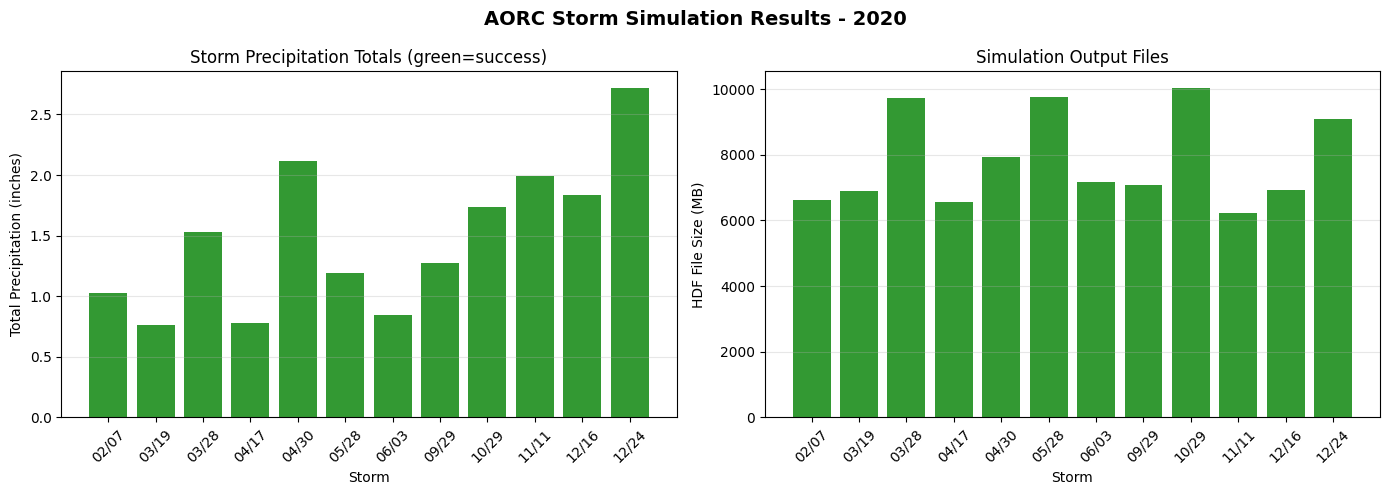

In [16]:
# Summary visualization
if storm_results:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Precipitation totals
    ax1 = axes[0]
    storm_dates = [r['start_time'].strftime('%m/%d') for r in storm_results]
    precip_totals = [r['total_depth_in'] for r in storm_results]
    colors = ['green' if r['exec_success'] else 'red' for r in storm_results]
    
    bars = ax1.bar(range(len(storm_results)), precip_totals, color=colors, alpha=0.8)
    ax1.set_xlabel('Storm')
    ax1.set_ylabel('Total Precipitation (inches)')
    ax1.set_title('Storm Precipitation Totals (green=success)')
    ax1.set_xticks(range(len(storm_results)))
    ax1.set_xticklabels(storm_dates, rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # HDF sizes
    ax2 = axes[1]
    hdf_sizes = [r['hdf_size_mb'] for r in storm_results]
    ax2.bar(range(len(storm_results)), hdf_sizes, color=colors, alpha=0.8)
    ax2.set_xlabel('Storm')
    ax2.set_ylabel('HDF File Size (MB)')
    ax2.set_title('Simulation Output Files')
    ax2.set_xticks(range(len(storm_results)))
    ax2.set_xticklabels(storm_dates, rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'AORC Storm Simulation Results - {YEAR}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Data Export Summary

All precipitation data has been exported to the project's `Precipitation/` folder:

In [17]:
# List all exported files
print(f"Precipitation Data Export Summary")
print(f"Location: {precip_folder}")
print("="*70)

# Count files
nc_files = list(precip_folder.glob("storm_*.nc"))
png_files = list(hyetograph_folder.glob("*.png"))
csv_files = list(precip_folder.glob("*.csv"))
summary_files = list(precip_folder.glob("storm_catalog_summary.png"))

print(f"\nExported Files:")
print(f"  Storm Catalog CSV:    {len(csv_files)} file(s)")
print(f"  NetCDF Precip Files:  {len(nc_files)} file(s)")
print(f"  Hyetograph PNGs:      {len(png_files)} file(s)")
print(f"  Summary Plot:         {len(summary_files)} file(s)")

# Calculate total size
total_size = sum(f.stat().st_size for f in nc_files + png_files + csv_files + summary_files)
print(f"\nTotal Size: {total_size / 1e6:.1f} MB")

print(f"\nFolder Structure:")
print(f"  Precipitation/")
print(f"    storm_catalog.csv")
print(f"    storm_catalog_summary.png")
print(f"    storm_YYYYMMDD.nc  (x{len(nc_files)})")
print(f"    hyetographs/")
print(f"      storm_YYYYMMDD_hyetograph.png  (x{len(png_files)})")

Precipitation Data Export Summary
Location: C:\GH\ras-commander\examples\example_projects_400_aorc_precipitation_catalog\BaldEagleCrkMulti2D_AORC_2020\Precipitation

Exported Files:
  Storm Catalog CSV:    1 file(s)
  NetCDF Precip Files:  12 file(s)
  Hyetograph PNGs:      12 file(s)
  Summary Plot:         1 file(s)

Total Size: 3.4 MB

Folder Structure:
  Precipitation/
    storm_catalog.csv
    storm_catalog_summary.png
    storm_YYYYMMDD.nc  (x12)
    hyetographs/
      storm_YYYYMMDD_hyetograph.png  (x12)


## Summary

This notebook demonstrated a complete AORC precipitation workflow:

1. **Project Setup** - Extracted example and created labeled working copy (with cleanup)
2. **Bounds Calculation** - Used `HdfProject.get_project_bounds_latlon()` with 50% buffer
3. **Storm Catalog** - Generated catalog using USGS standard parameters
4. **Precipitation Export** - Downloaded AORC data, exported CSV catalog and hyetograph plots
5. **Plan Creation** - Created HEC-RAS plans with precipitation written to HDF
6. **Parallel Execution** - Ran all plans with 2 cores and 3 workers

### Key Functions

| Function | Description |
|----------|-------------|
| `HdfProject.get_project_bounds_latlon()` | Get buffered bounds from geometry HDF |
| `PrecipAorc.get_storm_catalog()` | Generate catalog of precipitation events |
| `PrecipAorc.download()` | Download AORC data to NetCDF |
| `PrecipAorc.create_storm_plans()` | Create plans with precipitation in HDF |
| `RasCmdr.compute_parallel()` | Execute plans in parallel |

---
# Optional: Process All Available AORC Years (1979-2024)

The following cell processes storm catalogs for all available years in the AORC dataset.
Each year gets its own project folder with full precipitation data export.

**Warning**: This can take a very long time and generate many files!

In [19]:
# OPTIONAL: Process all AORC years
# Set PROCESS_ALL_YEARS = True to run

PROCESS_ALL_YEARS = False  # Set to True to run

if PROCESS_ALL_YEARS:
    import time

    # AORC is available from 1979-present for CONUS
    ALL_YEARS = list(range(1979, 2025))  # 1979-2024

    print(f"Processing {len(ALL_YEARS)} years of AORC data")
    print(f"Configuration: {NUM_CORES} cores x {MAX_WORKERS} workers per year")
    print("="*80)

    # Clean up ALL existing AORC folders first
    print("\nCleaning up existing AORC folders...")
    existing_folders = list(base_project.parent.glob("BaldEagleCrkMulti2D_AORC_*"))
    for folder in existing_folders:
        if folder.is_dir():
            print(f"  Removing: {folder.name}")
            shutil.rmtree(folder)
    print(f"  Removed {len(existing_folders)} existing folders")

    all_year_results = {}

    for year in ALL_YEARS:
        try:
            print(f"\n{'='*80}")
            print(f"PROCESSING YEAR: {year}")
            print(f"{'='*80}")

            # Create year-specific working folder
            year_folder = base_project.parent / f"BaldEagleCrkMulti2D_AORC_{year}"
            print(f"  Creating: {year_folder.name}")
            shutil.copytree(base_project, year_folder)

            # Initialize
            ras_year = init_ras_project(year_folder, RAS_VERSION)

            # Generate storm catalog
            print(f"  Generating storm catalog for {year}...")
            catalog = PrecipAorc.get_storm_catalog(
                bounds=bounds,
                year=year,
                inter_event_hours=8.0,
                min_depth_inches=0.75,
                buffer_hours=48
            )
            print(f"  Found {len(catalog)} storms")

            if len(catalog) == 0:
                print(f"  No storms found for {year}, skipping")
                all_year_results[year] = {'storms': 0, 'plans': 0, 'success': 0, 'elapsed_min': 0}
                continue

            # Create precipitation folder structure
            year_precip_folder = year_folder / "Precipitation"
            year_precip_folder.mkdir(exist_ok=True)
            year_hyetograph_folder = year_precip_folder / "hyetographs"
            year_hyetograph_folder.mkdir(exist_ok=True)

            # Export storm catalog to CSV
            catalog.to_csv(year_precip_folder / "storm_catalog.csv", index=False)
            print(f"  Exported storm catalog CSV")

            # Download precipitation and create plans
            print(f"  Downloading precipitation and creating plans...")
            year_plan_results = PrecipAorc.create_storm_plans(
                storm_catalog=catalog,
                bounds=bounds,
                template_plan=TEMPLATE_PLAN,
                precip_folder="Precipitation",
                ras_object=ras_year,
                download_data=True
            )

            # Generate hyetographs for each storm
            print(f"  Generating hyetograph plots...")
            for idx, storm in catalog.iterrows():
                storm_id = storm['storm_id']
                date_str = storm['start_time'].strftime('%Y%m%d')
                precip_file = year_precip_folder / f"storm_{date_str}.nc"

                if precip_file.exists():
                    ds = xr.open_dataset(precip_file)
                    da = ds['APCP_surface']
                    hourly_mean = da.mean(dim=['x', 'y']).values
                    times = pd.to_datetime(da.time.values)

                    fig, ax = plt.subplots(figsize=(12, 5))
                    ax.bar(times, hourly_mean, width=0.03, color='steelblue', alpha=0.8)
                    ax.set_title(f"Storm {storm_id}: {storm['start_time'].strftime('%B %d, %Y')}\n"
                                 f"Total: {storm['total_depth_in']:.2f} in | Peak: {storm['peak_intensity_in_hr']:.3f} in/hr",
                                 fontsize=12, fontweight='bold')
                    ax.set_xlabel('Date/Time')
                    ax.set_ylabel('Precipitation Rate (mm/hr)')
                    ax.tick_params(axis='x', rotation=45)
                    ax.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.savefig(year_hyetograph_folder / f"storm_{date_str}_hyetograph.png", dpi=150, bbox_inches='tight')
                    plt.close()
                    ds.close()

            # Create summary plot
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            axes[0].bar(catalog['storm_id'], catalog['total_depth_in'], color='steelblue', alpha=0.8)
            axes[0].set_xlabel('Storm ID')
            axes[0].set_ylabel('Total Depth (in)')
            axes[0].set_title('Precipitation Totals')
            axes[1].bar(catalog['storm_id'], catalog['peak_intensity_in_hr'], color='darkorange', alpha=0.8)
            axes[1].set_xlabel('Storm ID')
            axes[1].set_ylabel('Peak Intensity (in/hr)')
            axes[1].set_title('Peak Intensity')
            axes[2].bar(catalog['storm_id'], catalog['duration_hours'], color='green', alpha=0.8)
            axes[2].set_xlabel('Storm ID')
            axes[2].set_ylabel('Duration (hours)')
            axes[2].set_title('Storm Duration')
            plt.suptitle(f'Storm Catalog Summary - {year}', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.savefig(year_precip_folder / "storm_catalog_summary.png", dpi=150, bbox_inches='tight')
            plt.close()

            # Get plan numbers and execute
            plan_numbers = year_plan_results[year_plan_results['status'] == 'success']['plan_number'].tolist()
            print(f"  Created {len(plan_numbers)} plans")

            if len(plan_numbers) == 0:
                print(f"  No successful plans for {year}, skipping execution")
                all_year_results[year] = {'storms': len(catalog), 'plans': 0, 'success': 0, 'elapsed_min': 0}
                continue

            # Execute in parallel
            print(f"  Executing {len(plan_numbers)} plans ({NUM_CORES} cores x {MAX_WORKERS} workers)...")
            start_time = time.time()

            exec_results = RasCmdr.compute_parallel(
                plan_number=plan_numbers,
                max_workers=MAX_WORKERS,
                num_cores=NUM_CORES,
                ras_object=ras_year,
                overwrite_dest=True
            )

            elapsed = time.time() - start_time
            success = sum(1 for v in exec_results.values() if v)

            all_year_results[year] = {
                'storms': len(catalog),
                'plans': len(plan_numbers),
                'success': success,
                'elapsed_min': elapsed / 60
            }

            print(f"  Completed: {success}/{len(plan_numbers)} in {elapsed/60:.1f} minutes")

        except Exception as e:
            print(f"  ERROR processing {year}: {e}")
            all_year_results[year] = {'error': str(e)}

    # Final summary
    print("\n" + "="*80)
    print("ALL YEARS SUMMARY")
    print("="*80)

    total_storms = 0
    total_success = 0
    for year, res in sorted(all_year_results.items()):
        if 'error' in res:
            print(f"{year}: ERROR - {res['error']}")
        else:
            total_storms += res['storms']
            total_success += res['success']
            print(f"{year}: {res['storms']} storms, {res['success']}/{res['plans']} success, {res['elapsed_min']:.1f} min")

    print(f"\nTOTAL: {total_storms} storms, {total_success} successful simulations")
else:
    print("Set PROCESS_ALL_YEARS = True to process all AORC years (1979-2024)")
    print("Warning: This will take many hours and create ~50 project folders!")
    print("\nEach year will include:")
    print("  - Precipitation/storm_catalog.csv")
    print("  - Precipitation/storm_catalog_summary.png")
    print("  - Precipitation/storm_YYYYMMDD.nc (per storm)")
    print("  - Precipitation/hyetographs/storm_YYYYMMDD_hyetograph.png (per storm)")

Set PROCESS_ALL_YEARS = True to process all AORC years (1979-2024)

Each year will include:
  - Precipitation/storm_catalog.csv
  - Precipitation/storm_catalog_summary.png
  - Precipitation/storm_YYYYMMDD.nc (per storm)
  - Precipitation/hyetographs/storm_YYYYMMDD_hyetograph.png (per storm)
